In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [126]:
# Load data
HITS_PATH = "../data/TrackML/train_1/event000001000-hits.csv"
TRUTH_PATH = "../data/TrackML/train_1/event000001000-truth.csv"

# Pandas DataFrame
hits_df = pd.read_csv(HITS_PATH)
truth_df = pd.read_csv(TRUTH_PATH)

PT_MIN = 2 # GeV
ETA_MIN = -4
ETA_MAX = 4

In [139]:
def add_eta_phi_rows(df):
    """
    Add eta and phi columns to the DataFrame. Eta is the pseudorapidity and phi is the azimuthal angle.
    """
    df["r_xy"] = np.sqrt(df["x"]**2 + df["y"]**2)
    # df["theta"] = np.arctan2(df["r_xy"], df["z"]) # defined between 0 and pi
    df["theta"] = np.abs(np.arctan(df["r_xy"]/df["z"])) # defined between 0 and pi
    df["log_arg"] = np.tan(df["theta"]) / 2

    df["eta"] = - np.log(df["log_arg"])
    df["eta"] = df["eta"].clip(lower=0) * np.sign(df["z"])
    df["phi"] = np.arctan2(df["y"], df["x"])
    return df

def pT_filter(hits_df, truth_df, pT_min=2):
    # Apply truth pT filter to hits_df using truth_df. Exclude hits with pT < pt_min
    return hits_df[truth_df["pT"] > pT_min].copy()

def add_momentum(truth_df):
    """
    Add momentum columns to truth DataFrame.
    """
    truth_df["p"] = np.sqrt(truth_df["tpx"]**2 + truth_df["tpy"]**2 + truth_df["tpz"]**2)
    return truth_df

def add_pT(truth_df):
    """
    Add transverse momentum (pT) columns to truth DataFrame.
    """
    truth_df["pT"] = np.sqrt(truth_df["tpx"]**2 + truth_df["tpy"]**2)
    return truth_df

def noise_filter(hits_df, truth_df):
    """
    Remove hits not associated with any track in the truth DataFrame.
    """
    # In the TrackML dataset, these events will always have particle_id == 0 in truth_df
    return hits_df[truth_df["particle_id"] != 0].copy()


In [226]:
# Run DBSCAN clustering to build the graph
from sklearn.cluster import DBSCAN

hits_df = add_eta_phi_rows(hits_df)
truth_df = add_pT(truth_df)
hits_df = pT_filter(hits_df, truth_df, PT_MIN)
truth_df = add_momentum(truth_df)
hits_df = noise_filter(hits_df, truth_df)

# Extract features
features = hits_df[["eta", "phi"]].values
# Normalize features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
# DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(features)
# Add cluster labels to hits DataFrame
hits_df["cluster"] = clusters

/var/folders/vp/k8zj_r85147blp63h74mbprr0000gn/T/ipykernel_23758/1169163379.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/vp/k8zj_r85147blp63h74mbprr0000gn/T/ipykernel_23758/1169163379.py:38: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



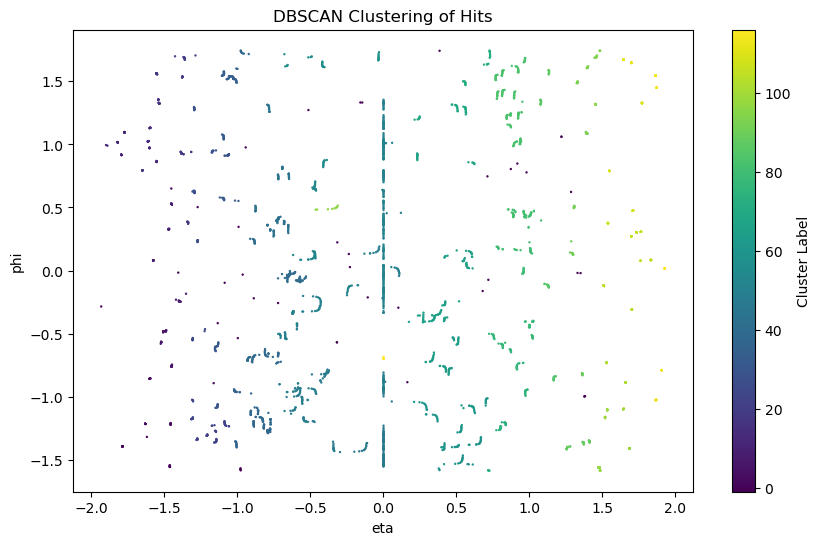

In [227]:
# Plot all x features
plt.figure(figsize=(10, 6))
# plt.scatter(features[:, 0], features[:, 1], c=hits_df["eta"], cmap="viridis", s=5)
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap="viridis", s=0.5)
plt.title("DBSCAN Clustering of Hits")
plt.xlabel("eta")
plt.ylabel("phi")
plt.colorbar(label="Cluster Label")
plt.show()

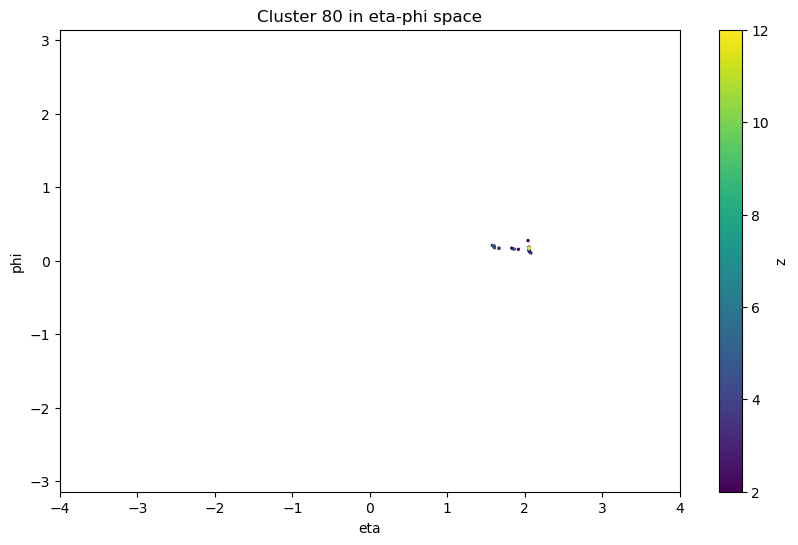

In [260]:
# Plot N random cluster in eta-phi space
def plot_cluster(cluster_id):
    cluster_hits = hits_df[hits_df["cluster"] == cluster_id]
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_hits["eta"], cluster_hits["phi"], c=cluster_hits["layer_id"], cmap="viridis", s=2)
    plt.title(f"Cluster {cluster_id} in eta-phi space")
    plt.xlabel("eta")
    plt.ylabel("phi")
    plt.xlim(-4, 4)
    plt.ylim(-3.14159, 3.14159)
    plt.colorbar(label="z")
    plt.show()

# Plot a random cluster
cluster_id = np.random.choice(hits_df["cluster"].unique())
plot_cluster(cluster_id)

In [261]:
# Assign random color to each cluster
def assign_colors_to_clusters(hits_df):
    unique_clusters = hits_df["cluster"].unique()
    np.random.shuffle(unique_clusters)
    colors = {cluster: np.random.rand(1,) for cluster in unique_clusters}
    hits_df["color"] = hits_df["cluster"].map(colors).astype(float)
    return hits_df
hits_df = assign_colors_to_clusters(hits_df)
# Plot clusters in 3D with Plotly
def plot_clusters_3d_plotly(hits_df):
    fig = px.scatter_3d(hits_df, x="x", y="y", z="z", color=hits_df['color'], color_continuous_scale="rainbow", opacity=1)
    fig.update_traces(marker=dict(size=1))
    fig.update_layout(title="3D Clustering of Hits", scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
    plotly.offline.plot(fig, filename='clusters_3d.html')
plot_clusters_3d_plotly(hits_df)

In [197]:
hits_df["color"]

26        [0.09543890968384539]
62         [0.6684440163002066]
171        [0.4300435715195823]
173       [0.03862260136229634]
302        [0.8073646368110574]
                  ...          
120864     [0.2583164694927159]
120865     [0.4543760906996914]
120884    [0.11139520996629337]
120915      [0.896526760310268]
120922      [0.896526760310268]
Name: color, Length: 3207, dtype: object

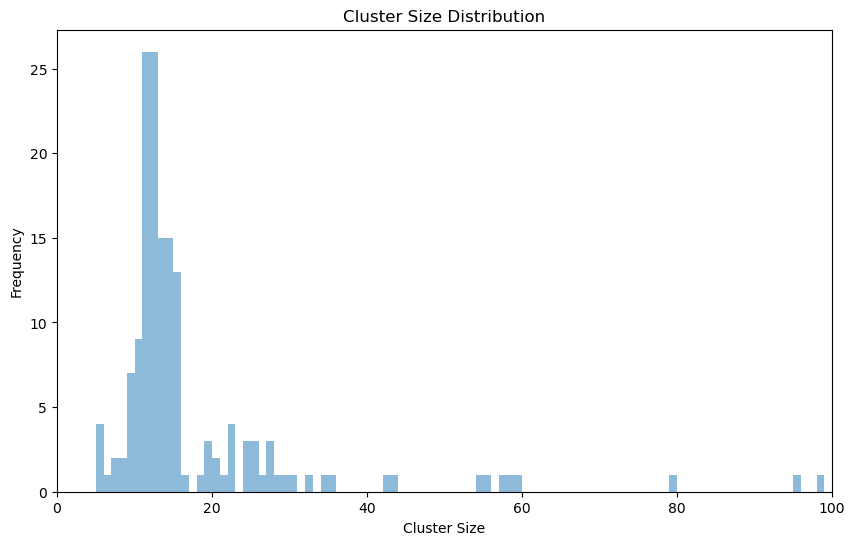

cluster
 55     138
 68     131
 63     108
 66     101
-1       98
       ... 
 28       6
 146      5
 84       5
 91       5
 160      5
Name: count, Length: 162, dtype: int64

In [212]:
# Plot cluster size distribution
x_max = 100

cluster_sizes = hits_df["cluster"].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(cluster_sizes, bins=100, range=(0, x_max), alpha=0.5)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.xlim(0, x_max)
plt.show()

unique_cluster_ids = hits_df["cluster"].unique()
cluster_sizes

In [97]:
hits_df[hits_df["cluster"] == 0].to_csv("hits_outliers.csv", index=False)

In [268]:
# 3D Scatter plot with plotly
def plot_3d_scatter(df, x_col, y_col, z_col, color_col=None):
    fig = px.scatter_3d(df, x=x_col, y=y_col, z=z_col, color=color_col)
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(scene=dict(xaxis_title=x_col, yaxis_title=y_col, zaxis_title=z_col))
    plotly.offline.plot(fig, filename="3d_scatter.html", auto_open=True)

# Plot 3D scatter plot of features
# plot_3d_scatter(hits_df, "x", "y", "z", color_col="eta")
plot_3d_scatter(hits_df, "x", "y", "z", color_col="color")


In [214]:


truth_df = add_momentum(truth_df)
truth_df = add_pT(truth_df)



# Parse truth dataframe to get truth tracks
unique_particles = truth_df["particle_id"].unique()
truth_tracks = {}
for particle_id in unique_particles:
    particle_hits = truth_df[truth_df["particle_id"] == particle_id]
    truth_tracks[particle_id] = {
        "hits": particle_hits,
        "tx": particle_hits["tx"].values,
        "ty": particle_hits["ty"].values,
        "tz": particle_hits["tz"].values,
        "tpx": particle_hits["tpx"].values,
        "tpy": particle_hits["tpy"].values,
        "tpz": particle_hits["tpz"].values,
        "p": particle_hits["p"].values,
        "pT": particle_hits["pT"].values,
    }

In [217]:
import plotly.graph_objects as go

# Plot first N truth tracks in 3D with plotly
def plot_truth_tracks(truth_tracks, N=10, include_bkg=False):
    # Randomize the order of the truth tracks
    particle_ids = list(truth_tracks.keys())
    np.random.shuffle(particle_ids)
    truth_tracks = {particle_id: truth_tracks[particle_id] for particle_id in particle_ids}
    fig = px.scatter_3d()
    for i, (particle_id, track) in enumerate(truth_tracks.items()):
        if not include_bkg and i == 0:
            continue
        if i >= N:
            break
        # p_mean = track["hits"]["pT"].mean()
        # p_norm = (p_mean - truth_df["p"].min()) / (truth_df["p"].max() - truth_df["p"].min())
        # color = px.colors.sample_colorscale("Viridis", p_norm)[0]
        color = px.colors.sample_colorscale("Viridis", i / N)[0]
        fig.add_trace(
            go.Scatter3d(
          x=track["hits"]["tx"],
          y=track["hits"]["ty"],
          z=track["hits"]["tz"],
          mode="lines",
          name=f"Particle {particle_id}",#, p={p_mean:.2f}",
          line=dict(width=2, color=color)
            )
        )
    fig.update_layout(scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z"))
    plotly.offline.plot(fig, filename="truth_tracks.html", auto_open=True)
  
# Plot truth tracks
plot_truth_tracks(truth_tracks, N=1000)

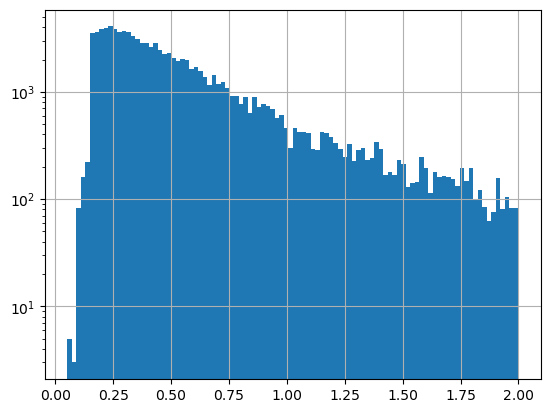

In [220]:
truth_df[truth_df["pT"] < 2]["pT"].hist(bins=100)
plt.yscale("log")